In [1]:
import pandas as pd
import numpy as np
import ivolatility as ivol
import matplotlib.pyplot as plt
import os
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

<h3><u>1) SPY 1-Month Option Chain Data Collection — April 9, 2025</u>

In [2]:
start_date = "2025-04-09"
one_day_before = "2025-04-08"
ticker = "SPY"
duartion = 30

moneyness = 5
call_moneyness = 1.05
put_moneyness = 0.95

In [3]:
def get_eod_option_series(
    symbol: str,
    trade_date: str,
    dte_from: int,
    dte_to: int,
    moneyness_from: float,
    moneyness_to: float,
    call_put: str = None,
    combined: bool = False,
    save_path: str = None
) -> pd.DataFrame:
    """
    Retrieve end-of-day option data for a given symbol and trade date
    from the IVolatility API using the /equities/eod/stock-opts-by-param
    endpoint, filtered by DTE, moneyness, and option type.

    Parameters
    ----------
    symbol : str
        Ticker symbol (e.g., "SPY").
    trade_date : str
        The trading date in "YYYY-MM-DD" format.
    dte_from : int
        Minimum days to expiration.
    dte_to : int
        Maximum days to expiration.
    moneyness_from : float
        Minimum moneyness.
    moneyness_to : float
        Maximum moneyness.
    call_put : str, optional
        "C" for calls, "P" for puts. Ignored if combined=True.
    combined : bool, optional
        If True, return both calls and puts combined. Default is False.
    save_path : str, optional
        File path to save the returned DataFrame. If provided, the data will be
        written to a CSV file.

    Returns
    -------
    pd.DataFrame
        DataFrame containing filtered option series data.
    """

    # Load API key
    api_key = os.getenv("API_KEY")
    if not api_key:
        raise ValueError("Environment variable 'API_KEY' is not set.")

    # Authenticate
    ivol.setLoginParams(apiKey=api_key)

    # Prepare endpoint
    getMarketData = ivol.setMethod('/equities/eod/stock-opts-by-param')

    def fetch(cp):
        return getMarketData(
            symbol=symbol,
            tradeDate=trade_date,
            dteFrom=dte_from,
            dteTo=dte_to,
            moneynessFrom=moneyness_from,
            moneynessTo=moneyness_to,
            cp=cp
        )

    # If combined, pull both calls and puts
    if combined:
        df_call = fetch("C")
        df_put = fetch("P")

        df = pd.concat([df_call, df_put], ignore_index=True)
        df = df.sort_values(by=["price_strike", "call_put"]).reset_index(drop=True)

    else:
        if call_put not in ("C", "P"):
            raise ValueError("call_put must be 'C' or 'P' unless combined=True.")
        df = fetch(call_put)

    # Save to CSV if requested
    if save_path:
        df.to_csv(save_path, index=False)

    return df

In [4]:
save_path = f"../data/option/eod_option_{ticker}_{"2025-05-02"}.csv"

df_test = get_eod_option_series(
    symbol=ticker,
    trade_date="2025-05-02",
    dte_from=7,
    dte_to=7,
    moneyness_from=-10000,
    moneyness_to=10000,
    call_put="C",
    combined=True,
    save_path=save_path
)


df_test

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-05-02,SPY 250509C00250000,7,627,2025-05-09,C,250.0,NaN,NaN,NaN,...,0.000000,-0.004451,0.000000,0.047905,318.50,315.66,566.62,-55.88,138505359,0
1,2025-05-02,SPY 250509P00250000,7,627,2025-05-09,P,250.0,NaN,NaN,NaN,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,566.62,55.88,138505360,0
2,2025-05-02,SPY 250509C00255000,7,627,2025-05-09,C,255.0,NaN,NaN,NaN,...,0.000000,-0.005050,0.000000,0.048863,313.50,310.67,566.62,-55.00,138505361,0
3,2025-05-02,SPY 250509P00255000,7,627,2025-05-09,P,255.0,NaN,NaN,NaN,...,0.000000,-0.000000,0.000000,-0.000000,0.01,0.00,566.62,55.00,138505362,0
4,2025-05-02,SPY 250509C00260000,7,627,2025-05-09,C,260.0,305.18,305.37,305.18,...,0.000000,-0.005650,0.000000,0.049821,308.52,305.67,566.62,-54.11,138505363,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,2025-05-02,SPY 250509P00640000,7,627,2025-05-09,P,640.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,74.39,71.58,566.62,-12.95,137973714,0
378,2025-05-02,SPY 250509C00645000,7,627,2025-05-09,C,645.0,0.01,0.02,0.01,...,0.000004,-0.000096,0.000059,0.000002,0.01,0.00,566.62,13.83,137973715,0
379,2025-05-02,SPY 250509P00645000,7,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,79.40,76.58,566.62,-13.83,137973716,0
380,2025-05-02,SPY 250509C00650000,7,627,2025-05-09,C,650.0,0.01,0.02,0.01,...,0.000001,-0.000033,0.000021,0.000001,0.01,0.00,566.62,14.72,137973717,0


In [5]:
save_path = f"../data/Option/eod_call_option_{ticker}_{start_date}.csv"

df_call = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=duartion,
    dte_to=duartion,
    moneyness_from=-10000,
    moneyness_to=10000,
    call_put="C",
    save_path=save_path
)

df_call

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509C00300000,30,627,2025-05-09,C,300.0,198.34,198.34,198.34,...,0.000224,-0.113122,0.055141,0.238799,246.57,243.12,543.37,-44.79,138169205,0
1,2025-04-09,SPY 250509C00305000,30,627,2025-05-09,C,305.0,195.95,195.95,195.95,...,0.000244,-0.119018,0.059110,0.242318,241.74,238.12,543.37,-43.87,138169207,0
2,2025-04-09,SPY 250509C00310000,30,627,2025-05-09,C,310.0,NaN,NaN,NaN,...,0.000263,-0.123925,0.062721,0.245885,236.84,233.17,543.37,-42.95,138169209,0
3,2025-04-09,SPY 250509C00315000,30,627,2025-05-09,C,315.0,NaN,NaN,NaN,...,0.000244,-0.105663,0.054542,0.251238,231.50,228.11,543.37,-42.03,138169211,0
4,2025-04-09,SPY 250509C00320000,30,627,2025-05-09,C,320.0,NaN,NaN,NaN,...,0.000280,-0.119192,0.062859,0.254106,226.68,223.28,543.37,-41.11,138169213,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-09,SPY 250509C00630000,30,627,2025-05-09,C,630.0,NaN,NaN,NaN,...,0.000749,-0.014068,0.038542,0.004020,0.13,0.07,543.37,15.94,137973709,0
136,2025-04-09,SPY 250509C00635000,30,627,2025-05-09,C,635.0,0.06,0.11,0.06,...,0.000673,-0.013706,0.036099,0.003728,0.12,0.05,543.37,16.86,137973711,0
137,2025-04-09,SPY 250509C00640000,30,627,2025-05-09,C,640.0,0.03,0.05,0.03,...,0.000611,-0.013426,0.034044,0.003485,0.12,0.05,543.37,17.78,137973713,0
138,2025-04-09,SPY 250509C00645000,30,627,2025-05-09,C,645.0,0.03,0.03,0.03,...,0.000558,-0.013216,0.032307,0.003281,0.11,0.07,543.37,18.70,137973715,0


In [6]:
save_path = f"../data/option/eod_put_option_{ticker}_{start_date}.csv"

df_put = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=duartion,
    dte_to=duartion,
    moneyness_from=-10000,
    moneyness_to=10000,
    call_put="P",
    save_path=save_path
)

df_put

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509P00300000,30,627,2025-05-09,P,300.0,0.98,0.98,0.17,...,0.000109,-0.031580,0.022532,-0.002419,0.25,0.20,543.37,44.79,138169206,0
1,2025-04-09,SPY 250509P00305000,30,627,2025-05-09,P,305.0,0.84,1.04,0.31,...,0.000121,-0.033753,0.024468,-0.002652,0.27,0.22,543.37,43.87,138169208,0
2,2025-04-09,SPY 250509P00310000,30,627,2025-05-09,P,310.0,1.09,1.09,0.31,...,0.000131,-0.035309,0.026089,-0.002848,0.29,0.23,543.37,42.95,138169210,0
3,2025-04-09,SPY 250509P00315000,30,627,2025-05-09,P,315.0,1.12,1.18,0.33,...,0.000147,-0.038463,0.028794,-0.003183,0.32,0.26,543.37,42.03,138169212,0
4,2025-04-09,SPY 250509P00320000,30,627,2025-05-09,P,320.0,1.25,1.30,0.19,...,0.000167,-0.043090,0.032533,-0.003657,0.39,0.28,543.37,41.11,138169214,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,2025-04-09,SPY 250509P00630000,30,627,2025-05-09,P,630.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,87.95,84.64,543.37,-15.94,137973710,0
136,2025-04-09,SPY 250509P00635000,30,627,2025-05-09,P,635.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,92.95,89.64,543.37,-16.86,137973712,0
137,2025-04-09,SPY 250509P00640000,30,627,2025-05-09,P,640.0,106.00,110.00,106.00,...,0.000000,0.000000,0.000000,0.000000,97.95,94.64,543.37,-17.78,137973714,0
138,2025-04-09,SPY 250509P00645000,30,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,102.95,99.64,543.37,-18.70,137973716,0


In [7]:
df_call_five_percent = df_call[(df_call['calc_OTM'] >= 5) & (df_call['calc_OTM'] <= 5.5)]
df_call_five_percent

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
110,2025-04-09,SPY 250509C00571000,30,627,2025-05-09,C,571.0,1.08,5.05,0.89,...,0.009197,-0.176452,0.470783,0.098448,4.43,4.02,543.37,5.08,137937929,0
111,2025-04-09,SPY 250509C00572000,30,627,2025-05-09,C,572.0,1.00,4.66,0.84,...,0.008984,-0.173608,0.461797,0.095179,4.38,3.74,543.37,5.27,137937931,0
112,2025-04-09,SPY 250509C00572500,30,627,2025-05-09,C,572.5,1.10,3.63,0.89,...,0.008925,-0.167681,0.452360,0.091916,4.00,3.65,543.37,5.36,137937933,0
113,2025-04-09,SPY 250509C00573000,30,627,2025-05-09,C,573.0,0.94,3.96,0.77,...,0.008832,-0.164510,0.445791,0.089688,3.87,3.51,543.37,5.45,137937935,0


In [8]:
df_put_five_percent = df_put[(df_put['calc_OTM'] >= 5) & (df_put['calc_OTM'] <= 5.5)]
df_put_five_percent

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
50,2025-04-09,SPY 250509P00514000,30,627,2025-05-09,P,514.0,26.93,26.93,7.38,...,0.006327,-0.259627,0.509862,-0.106732,8.24,7.88,543.37,5.41,138102020,0
51,2025-04-09,SPY 250509P00515000,30,627,2025-05-09,P,515.0,33.68,34.56,7.44,...,0.006436,-0.260834,0.510681,-0.109063,8.46,8.06,543.37,5.22,137973690,0
52,2025-04-09,SPY 250509P00516000,30,627,2025-05-09,P,516.0,33.89,33.89,7.75,...,0.006544,-0.262369,0.511510,-0.111529,8.71,8.24,543.37,5.04,138102022,0


In [9]:
#Check that the underlying price of the asset is the same provided by the option chain api
print(len(list(set(df_put['underlying_price']) & set(df_call['underlying_price']))))
spot_today = list(set(df_put['underlying_price']) & set(df_call['underlying_price']))[0]
spot_today

1


543.37

In [10]:
dfs = [df_call_five_percent, df_put_five_percent]

#Take the row from each df with the smallest cal_OTM closest to 5%
smallest_rows = [df.loc[df["calc_OTM"].idxmin()] for df in dfs]

# combine into one DataFrame
df_option_five_percent_otm = pd.DataFrame(smallest_rows)
df_option_five_percent_otm.to_csv("../data/Option/eod_option_5%_OTM_2025-04-09.csv", index=False)

df_option_five_percent_otm

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
110,2025-04-09,SPY 250509C00571000,30,627,2025-05-09,C,571.0,1.08,5.05,0.89,...,0.009197,-0.176452,0.470783,0.098448,4.43,4.02,543.37,5.08,137937929,0
52,2025-04-09,SPY 250509P00516000,30,627,2025-05-09,P,516.0,33.89,33.89,7.75,...,0.006544,-0.262369,0.511510,-0.111529,8.71,8.24,543.37,5.04,138102022,0



Based on the options data API endpoint, As of 2025/04/09 EOD, the underlying SPY price was 543.37.
the closest 1-month 5% Out-of-the-Money (OTM) options expiring on 2025/05/09 strike prices were:
- **Call:** Strike 571.0, which is 5.08% OTM.
- **Put:** Strike 516.0, which is 5.04% OTM.

We will work with these two 5% OTM options in the future analysis.

In [11]:
save_path = f"../data/option/eod_option_{ticker}_{start_date}.csv"

df_option_combined = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=duartion,
    dte_to=duartion,
    moneyness_from=-10000,
    moneyness_to=10000,
    call_put="C",
    combined=True,
    save_path=save_path
)


df_option_combined

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250509C00300000,30,627,2025-05-09,C,300.0,198.34,198.34,198.34,...,0.000224,-0.113122,0.055141,0.238799,246.57,243.12,543.37,-44.79,138169205,0
1,2025-04-09,SPY 250509P00300000,30,627,2025-05-09,P,300.0,0.98,0.98,0.17,...,0.000109,-0.031580,0.022532,-0.002419,0.25,0.20,543.37,44.79,138169206,0
2,2025-04-09,SPY 250509C00305000,30,627,2025-05-09,C,305.0,195.95,195.95,195.95,...,0.000244,-0.119018,0.059110,0.242318,241.74,238.12,543.37,-43.87,138169207,0
3,2025-04-09,SPY 250509P00305000,30,627,2025-05-09,P,305.0,0.84,1.04,0.31,...,0.000121,-0.033753,0.024468,-0.002652,0.27,0.22,543.37,43.87,138169208,0
4,2025-04-09,SPY 250509C00310000,30,627,2025-05-09,C,310.0,NaN,NaN,NaN,...,0.000263,-0.123925,0.062721,0.245885,236.84,233.17,543.37,-42.95,138169209,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2025-04-09,SPY 250509P00640000,30,627,2025-05-09,P,640.0,106.00,110.00,106.00,...,0.000000,0.000000,0.000000,0.000000,97.95,94.64,543.37,-17.78,137973714,0
276,2025-04-09,SPY 250509C00645000,30,627,2025-05-09,C,645.0,0.03,0.03,0.03,...,0.000558,-0.013216,0.032307,0.003281,0.11,0.07,543.37,18.70,137973715,0
277,2025-04-09,SPY 250509P00645000,30,627,2025-05-09,P,645.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.000000,102.95,99.64,543.37,-18.70,137973716,0
278,2025-04-09,SPY 250509C00650000,30,627,2025-05-09,C,650.0,0.04,0.10,0.04,...,0.000421,-0.009971,0.024398,0.002391,0.06,0.03,543.37,19.62,137973717,0


In [12]:
df_call_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=duartion-1,
    dte_to=duartion+1,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="C",
    save_path=None
)


df_put_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=duartion-1,
    dte_to=duartion+1,
    moneyness_from=-100,
    moneyness_to=100,
    call_put="P",
    save_path=None
)

#Check that the underlying price of the asset yesterday is the same provided by the option chain api
print(len(list(set(df_put_one_day_before['underlying_price']) & set(df_call_one_day_before['underlying_price']))))
spot_yst = list(set(df_put_one_day_before['underlying_price']) & set(df_call_one_day_before['underlying_price']))[0]
spot_yst

1


496.74

<h3><u>2) Exploration of the SPY Implied Volatility Surface</u>

In [13]:
def plot_iv_call_and_put(
    call_df,
    put_df,
    mode="moneyness",
    underlying_price=None,
    date=None,
    dte_col="dte",
    iv_col="iv",
    underlying_label="SPY",
):
    """
    Plot call and put implied volatility either:
      - versus moneyness (strike / underlying)
      - versus time to maturity (term structure)

    Parameters
    ----------
    call_df : pd.DataFrame
        DataFrame with call option data. Must contain:
        - "price_strike"
        - iv_col (default "iv")
        - dte_col (default "dte") if mode="tenor"
    put_df : pd.DataFrame
        DataFrame with put option data. Must contain:
        - "price_strike"
        - iv_col (default "iv")
        - dte_col (default "dte") if mode="tenor"
    mode : {"moneyness", "tenor"}
        If "moneyness": plot IV vs strike/underlying (%)  
        If "tenor"   : plot IV vs DTE / term structure
    underlying_price : float, optional
        Current underlying spot price (required if mode="moneyness").
    date : str, optional
        Date string to display in the plot title.
    dte_col : str, default "dte"
        Column name containing time to maturity (e.g., days to expiry).
    iv_col : str, default "iv"
        Column name containing implied volatility in decimal (e.g., 0.25).
    underlying_label : str, default "SPY"
        Label/symbol used in the plot title.
    """

    if mode not in {"moneyness", "tenor"}:
        raise ValueError("mode must be either 'moneyness' or 'tenor'")

    if mode == "moneyness" and underlying_price is None:
        raise ValueError("underlying_price is required when mode='moneyness'")

    plt.figure(figsize=(10, 6))

    # --- Plot Calls ---
    if call_df is not None and not call_df.empty:
        call_df = call_df.copy()

        if mode == "moneyness":
            x_call = call_df["price_strike"] / underlying_price * 100
            x_label = "Moneyness (%)"
            title_core = f"{underlying_label} IV Curve with (Spot: {underlying_price})"
        else:  # mode == "tenor"
            x_call = call_df[dte_col]
            x_label = "Time to Maturity"
            title_core = f"{underlying_label} ATM IV Term Structure with (Spot: {underlying_price})"

        plt.plot(
            x_call,
            call_df[iv_col] * 100,
            label="Calls",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- Plot Puts ---
    if put_df is not None and not put_df.empty:
        put_df = put_df.copy()

        if mode == "moneyness":
            x_put = put_df["price_strike"] / underlying_price * 100
        else:  # mode == "tenor"
            x_put = put_df[dte_col]

        plt.plot(
            x_put,
            put_df[iv_col] * 100,
            label="Puts",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- Labels & Title ---
    plt.xlabel(x_label)
    plt.ylabel("Implied Volatility (%)")

    if date is not None:
        plt.title(f"{title_core} on {date}")
    else:
        plt.title(title_core)

    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_iv_call_and_put_two_dates(
    call_df_1,
    put_df_1,
    underlying_price_1,
    date_1,
    call_df_2,
    put_df_2,
    underlying_price_2,
    date_2,
    iv_col="iv",
    underlying_label="SPY",
    mode="moneyness",   # "moneyness" or "tenor"
    dte_col="dte",      # used when mode="tenor"
):
    """
    Plot call and put implied volatility curves for two dates on the same figure.

    Parameters
    ----------
    call_df_1, put_df_1 : pd.DataFrame
        Call/put data for date_1.
        Must contain:
          - "price_strike" and iv_col if mode="moneyness"
          - dte_col and iv_col if mode="tenor"
    call_df_2, put_df_2 : pd.DataFrame
        Call/put data for date_2 with same column requirements.
    underlying_price_1 : float or None
        Spot price for date_1 (required if mode="moneyness"; ignored if mode="tenor").
    underlying_price_2 : float or None
        Spot price for date_2 (required if mode="moneyness"; ignored if mode="tenor").
    date_1, date_2 : str
        Labels/dates used in the legend and title.
    iv_col : str, default "iv"
        Column name for implied volatility (in decimal, e.g. 0.25).
    underlying_label : str, default "SPY"
        Symbol/text for chart title.
    mode : {"moneyness", "tenor"}
        - "moneyness": x-axis is strike/underlying * 100
        - "tenor": x-axis is dte_col
    dte_col : str, default "dte"
        Column name for time to maturity if mode="tenor".
    """

    if mode not in {"moneyness", "tenor"}:
        raise ValueError("mode must be either 'moneyness' or 'tenor'")

    if mode == "moneyness" and (underlying_price_1 is None or underlying_price_2 is None):
        raise ValueError("underlying_price_1 and underlying_price_2 are required when mode='moneyness'")

    plt.figure(figsize=(10, 6))

    # Decide axis label & base title
    if mode == "moneyness":
        x_label = "Moneyness (%)"
        title_core = f"{underlying_label} 1-Month IV Curve"
    else:  # mode == "tenor"
        x_label = "Time to Maturity (Days)"
        title_core = f"{underlying_label} IV Term Structure"

    # --- First date ---
    if call_df_1 is not None and not call_df_1.empty:
        c1 = call_df_1.copy()
        if mode == "moneyness":
            x_c1 = c1["price_strike"] / underlying_price_1 * 100
        else:
            x_c1 = c1[dte_col]

        plt.plot(
            x_c1,
            c1[iv_col] * 100,
            label=f"Calls ({date_1})",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    if put_df_1 is not None and not put_df_1.empty:
        p1 = put_df_1.copy()
        if mode == "moneyness":
            x_p1 = p1["price_strike"] / underlying_price_1 * 100
        else:
            x_p1 = p1[dte_col]

        plt.plot(
            x_p1,
            p1[iv_col] * 100,
            label=f"Puts ({date_1})",
            marker="o",
            linestyle="-",
            linewidth=2,
            markersize=5,
        )

    # --- Second date ---
    if call_df_2 is not None and not call_df_2.empty:
        c2 = call_df_2.copy()
        if mode == "moneyness":
            x_c2 = c2["price_strike"] / underlying_price_2 * 100
        else:
            x_c2 = c2[dte_col]

        plt.plot(
            x_c2,
            c2[iv_col] * 100,
            label=f"Calls ({date_2})",
            marker="s",
            linestyle="--",
            linewidth=2,
            markersize=5,
        )

    if put_df_2 is not None and not put_df_2.empty:
        p2 = put_df_2.copy()
        if mode == "moneyness":
            x_p2 = p2["price_strike"] / underlying_price_2 * 100
        else:
            x_p2 = p2[dte_col]

        plt.plot(
            x_p2,
            p2[iv_col] * 100,
            label=f"Puts ({date_2})",
            marker="s",
            linestyle="--",
            linewidth=2,
            markersize=5,
        )

    plt.xlabel(x_label)
    plt.ylabel("Implied Volatility (%)")
    plt.title(f"{title_core} on {date_1} vs {date_2}")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


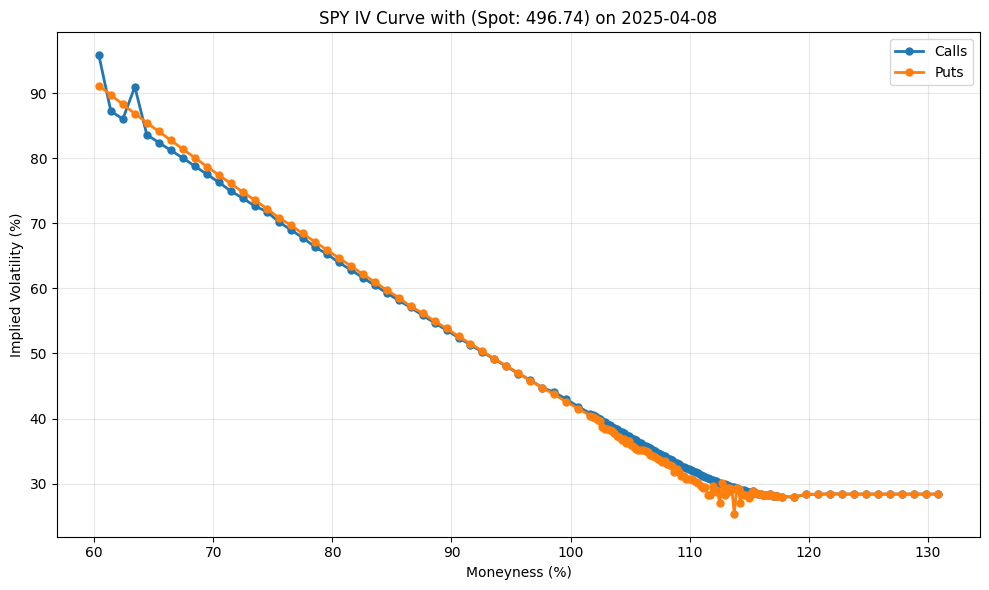

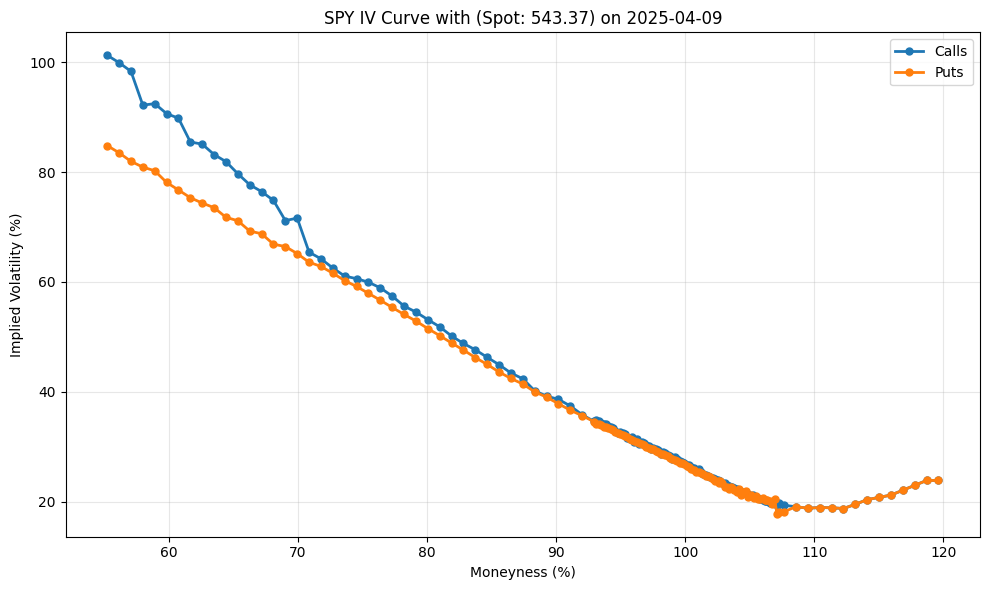

In [14]:
plot_iv_call_and_put(
    df_call_one_day_before,
    df_put_one_day_before,
    mode="moneyness",
    underlying_price=spot_yst,
    date=one_day_before
)

plot_iv_call_and_put(
    df_call,
    df_put,
    mode="moneyness",
    underlying_price=spot_today,
    date=start_date
)


#### <u>Interpretation of Call–Put IV Behavior Across Moneyness on 2025-04-09</u>

From **~380 (70% moneyness)** to **~650 (120% moneyness)** strikes, the call and put implied volatilities track each other almost perfectly. This is expected: for options with the same strike and maturity on the same underlying, implied volatilities must be equal. This follows directly from **model-independent put–call parity**, which holds in an efficient, no-arbitrage market.
In this highly liquid region, spreads are tight, pricing is efficient, and call/put IVs align closely.

Below **~380 (70% moneyness)**, the curves begin to separate, with **call IV rising above put IV**. This occurs because these strikes fall into the **deep-in-the-money region for calls** (and deep OTM for puts).

This divergence is mainly due to:

1. **American exercise optionality** — deep ITM calls may have early-exercise value, breaking the clean call–put symmetry seen near ATM.
2. **Lower liquidity in the wings** — wider spreads amplify small price differences into larger IV differences.
3. **Less stable IV surface far from ATM** — extrapolation and sparse data cause natural IV discrepancies even without arbitrage.

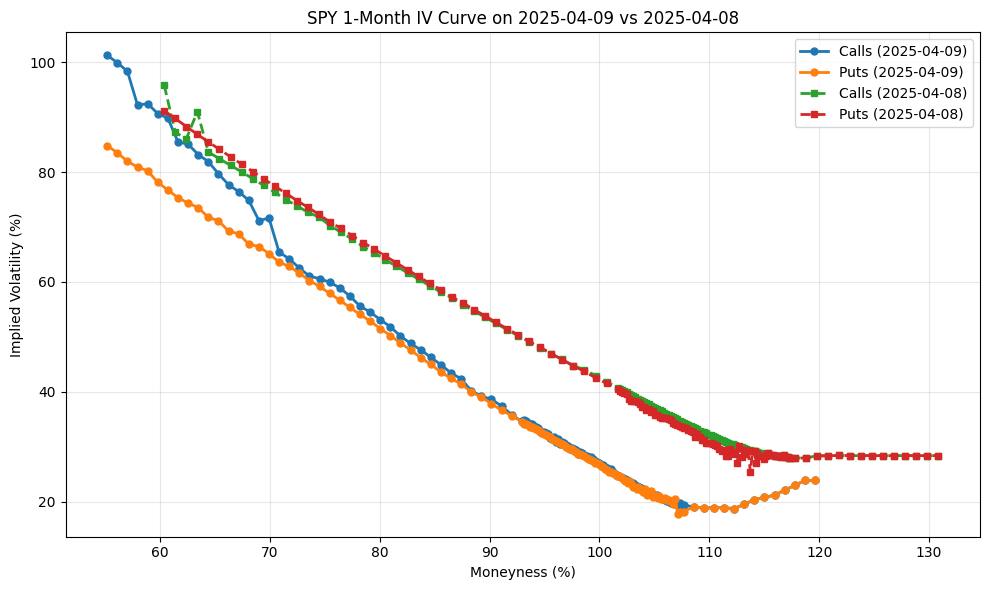

In [15]:
plot_iv_call_and_put_two_dates(
    call_df_1=df_call,
    put_df_1=df_put,
    underlying_price_1=spot_today,
    date_1=start_date,
    call_df_2=df_call_one_day_before,
    put_df_2=df_put_one_day_before,
    underlying_price_2=spot_yst,
    date_2=one_day_before,
    mode="moneyness",
)

### <u>Why the IV Curve Declined Across All Moneyness After the April 9 Rally ?</u>

The broad decline in implied volatility across all strikes following the strong April 9 rally reflects a typical market response to reduced uncertainty and improved risk sentiment. Large upward moves in the underlying often signal clearer direction, lower perceived downside risk, and diminished demand for protective puts, all of which compress implied volatility. As put demand falls, put IV drops first, and call IV follows through put–call parity, causing the entire surface to shift downward. With realized volatility also expected to decrease after a stable, directionally strong price move, the market reprices options with lower implied vol across the full moneyness range.


In [16]:
df_call_atm_term_structure = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

df_put_atm_term_structure = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="P",
    save_path=None
)

df_call_atm_term_structure_one_day_before= get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

df_put_atm_term_structure_one_day_before= get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=100000,
    moneyness_from=-0.1,
    moneyness_to=0.1,
    call_put="C",
    save_path=None
)

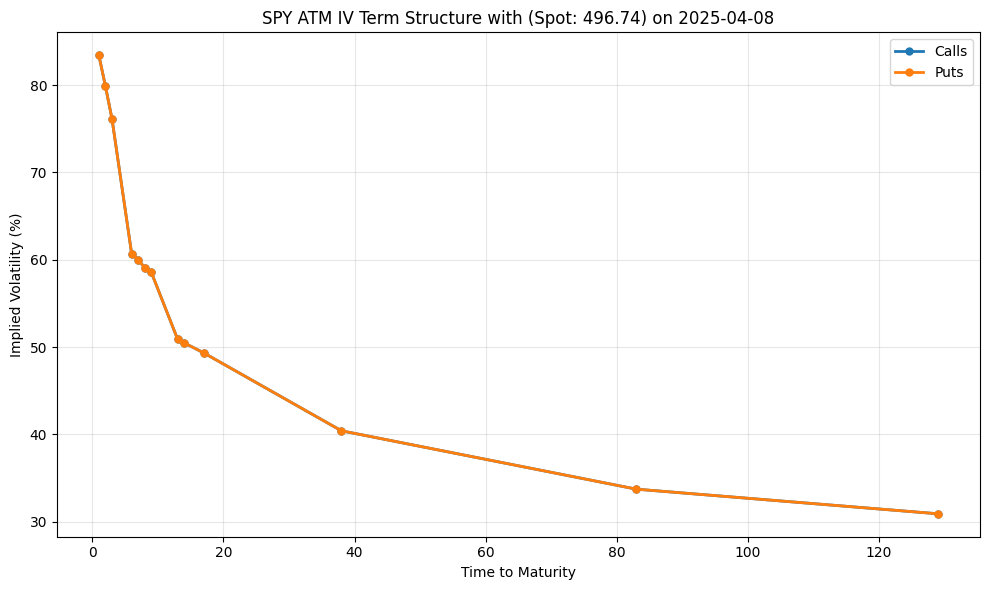

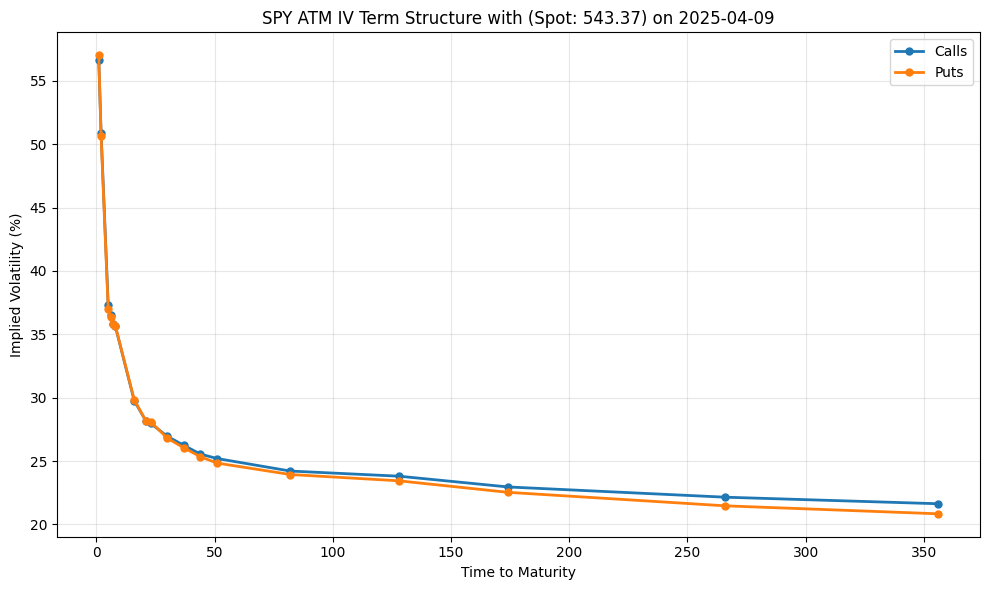

In [17]:
plot_iv_call_and_put(
    df_call_atm_term_structure_one_day_before,
    df_put_atm_term_structure_one_day_before,
    mode="tenor",
    underlying_price=spot_yst,
    date=one_day_before
)

plot_iv_call_and_put(
    df_call_atm_term_structure,
    df_put_atm_term_structure,
    mode="tenor",
    underlying_price=spot_today,
    date=start_date
)

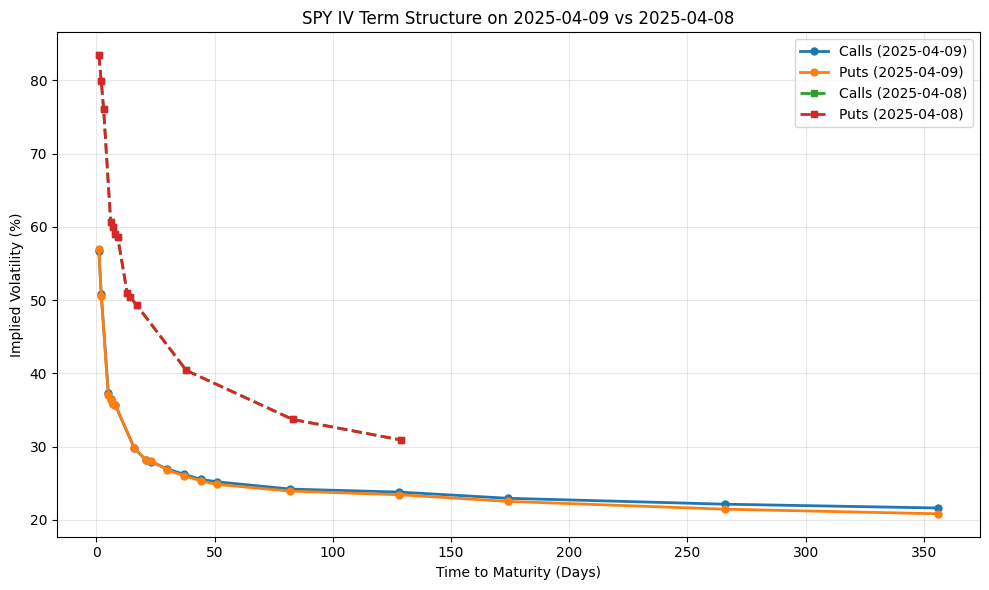

In [18]:
plot_iv_call_and_put_two_dates(
    call_df_1=df_call_atm_term_structure,
    put_df_1=df_put_atm_term_structure,
    underlying_price_1=None,
    date_1=start_date,
    call_df_2=df_call_atm_term_structure_one_day_before,
    put_df_2=df_put_atm_term_structure_one_day_before,
    underlying_price_2=None,
    date_2=one_day_before,
    mode="tenor",
    dte_col="dte",
)

### <u>Why the IV Term Structure is inverted to be begin with?</u>

SPY’s IV term structure inverted on 2025-04-08 because markets were bracing for immediate volatility from the U.S.–China tariff clash taking effect that week, causing short-dated options to carry heavy event-risk premium while longer maturities did not.

### <u>Why the IV Term Structure Shifted Lower After the April 9 Rally ?</u>

The downward shift in the entire implied volatility term structure on April 9 mirrors the broad decline seen in the moneyness curve. A strong market rally reduces perceived risk and uncertainty across all horizons, lowering expected future volatility and decreasing the demand for downside protection. As put premiums compress and hedging activity fades, implied vol falls for both short- and long-dated maturities, and call IV adjusts through put–call parity. The result is a uniformly lower term structure, with the largest drop in the shortest expiries where sensitivity to changes in market sentiment and hedging flows is strongest.

<h3><u>3) Constructing of the SPY Implied Volatility Surface</u>

In [19]:
df_call_iv_surface = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="C",
    save_path=None
)

df_put_iv_surface = get_eod_option_series(
    symbol=ticker,
    trade_date=start_date,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="P",
    save_path=None
)

df_call_iv_surface_one_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="C",
    save_path=None
)

df_put_iv_surface_onde_day_before = get_eod_option_series(
    symbol=ticker,
    trade_date=one_day_before,
    dte_from=1,
    dte_to=3000,
    moneyness_from=-1000,
    moneyness_to=1000,
    call_put="P",
    save_path=None
)

df_call_iv_surface

,c_date,option_symbol,dte,stocks_id,expiration_date,call_put,price_strike,price_open,price_high,price_low,...,gamma,theta,vega,rho,Ask,Bid,underlying_price,calc_OTM,option_id,is_settlement
0,2025-04-09,SPY 250410C00300000,1,627,2025-04-10,C,300.0,201.08,243.79,201.08,...,0.000000,0.000000,0.000000,0.008218,245.20,242.06,543.37,-44.79,138167653,0
1,2025-04-09,SPY 250410C00305000,1,627,2025-04-10,C,305.0,NaN,NaN,NaN,...,0.000000,0.000000,0.000000,0.008355,240.20,237.06,543.37,-43.87,138167655,0
2,2025-04-09,SPY 250410C00310000,1,627,2025-04-10,C,310.0,190.81,190.81,190.81,...,0.000000,0.000000,0.000000,0.008492,235.20,232.06,543.37,-42.95,138167657,0
3,2025-04-09,SPY 250410C00315000,1,627,2025-04-10,C,315.0,185.62,185.62,185.62,...,0.000000,0.000000,0.000000,0.008629,230.25,227.06,543.37,-42.03,138167659,0
4,2025-04-09,SPY 250410C00320000,1,627,2025-04-10,C,320.0,180.01,181.16,180.01,...,0.000000,0.000000,0.000000,0.008766,225.20,222.06,543.37,-41.11,138167661,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5670,2025-04-09,SPY 271217C00895000,982,627,2027-12-17,C,895.0,NaN,NaN,NaN,...,0.000686,-0.006907,0.768668,0.537499,2.57,1.26,543.37,64.71,136409151,0
5671,2025-04-09,SPY 271217C00900000,982,627,2027-12-17,C,900.0,1.00,1.90,1.00,...,0.000658,-0.006619,0.737706,0.511304,1.95,1.62,543.37,65.63,136409153,0
5672,2025-04-09,SPY 271217C00905000,982,627,2027-12-17,C,905.0,NaN,NaN,NaN,...,0.000632,-0.006355,0.708986,0.487279,2.24,1.11,543.37,66.55,136845307,0
5673,2025-04-09,SPY 271217C00910000,982,627,2027-12-17,C,910.0,1.57,1.57,1.06,...,0.000607,-0.006100,0.681246,0.464344,2.10,1.10,543.37,67.47,136875983,0


In [20]:
def plot_iv_surfaces(df_call_iv_surface, df_put_iv_surface, spot_price, as_of_date):
    """
    Plot a 3D IV surface using:
      - call IV where calls are OTM (strike > spot_price)
      - put IV where puts are OTM (strike < spot_price)
      - average of call & put IV where strike == spot_price

    Parameters
    ----------
    df_call_iv_surface : pd.DataFrame
        Must contain columns: ['price_strike', 'expiration_date', 'iv']
    df_put_iv_surface : pd.DataFrame
        Must contain columns: ['price_strike', 'expiration_date', 'iv']
    spot_price : float
        Underlying spot price used for OTM/ATM logic and in plot title.
    as_of_date : str
        String date for titles, e.g. "2025/04/09"
    """

    # --- Ensure expiration_date is numeric (days) and aligned across both DFs ---
    # If either is non-numeric, treat both as dates and convert to days from global min
    if (not np.issubdtype(df_call_iv_surface['expiration_date'].dtype, np.number) or
        not np.issubdtype(df_put_iv_surface['expiration_date'].dtype, np.number)):
        
        df_call_iv_surface = df_call_iv_surface.copy()
        df_put_iv_surface = df_put_iv_surface.copy()

        df_call_iv_surface['expiration_date'] = pd.to_datetime(df_call_iv_surface['expiration_date'])
        df_put_iv_surface['expiration_date']  = pd.to_datetime(df_put_iv_surface['expiration_date'])

        base_date = min(df_call_iv_surface['expiration_date'].min(),
                        df_put_iv_surface['expiration_date'].min())

        df_call_iv_surface['expiration_date'] = (df_call_iv_surface['expiration_date'] - base_date).dt.days
        df_put_iv_surface['expiration_date']  = (df_put_iv_surface['expiration_date']  - base_date).dt.days

    # --- Merge call & put surfaces on (strike, expiration) ---
    call = df_call_iv_surface[['price_strike', 'expiration_date', 'iv']].rename(columns={'iv': 'call_iv'})
    put  = df_put_iv_surface[['price_strike', 'expiration_date', 'iv']].rename(columns={'iv': 'put_iv'})

    merged = pd.merge(
        call,
        put,
        on=['price_strike', 'expiration_date'],
        how='outer'
    )

    # Remove potential duplicates just in case
    merged = merged.drop_duplicates(subset=['price_strike', 'expiration_date'])

    # --- Construct combined OTM IV ---
    def choose_iv(row):
        k   = row['price_strike']
        civ = row.get('call_iv')
        piv = row.get('put_iv')

        # ATM: strike == spot → average when both available
        if np.isclose(k, spot_price):
            if pd.notna(civ) and pd.notna(piv):
                return 0.5 * (civ + piv)
            elif pd.notna(civ):
                return civ
            else:
                return piv

        # OTM call region: strike > spot → prefer call IV
        if k > spot_price:
            if pd.notna(civ):
                return civ
            else:
                return piv  # fallback if call missing

        # OTM put region: strike < spot → prefer put IV
        if k < spot_price:
            if pd.notna(piv):
                return piv
            else:
                return civ  # fallback if put missing

        return np.nan

    merged['iv_otm'] = merged.apply(choose_iv, axis=1)
    merged = merged.dropna(subset=['iv_otm'])

    # --- Plot combined OTM IV surface ---
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_trisurf(
        (merged['price_strike'] / spot_price) * 100,
        merged['expiration_date'],
        merged['iv_otm'] * 100,
        cmap=cm.viridis,
        linewidth=0.2,
        antialiased=True
    )

    ax.set_title(
        f"SPY (SPDR S&P 500 ETF) IV Surface on {as_of_date} "
        f"(Spot: {spot_price})"
    )
    ax.set_xlabel("Moneyness (%)")
    ax.set_ylabel("Expiration (days)")
    ax.set_zlabel("Implied Volatility (%)", labelpad=20)
    ax.zaxis.label.set_rotation(90)

    plt.tight_layout()
    fig.subplots_adjust(left=0.08, right=0.95, bottom=0.07, top=0.93)
    plt.show()


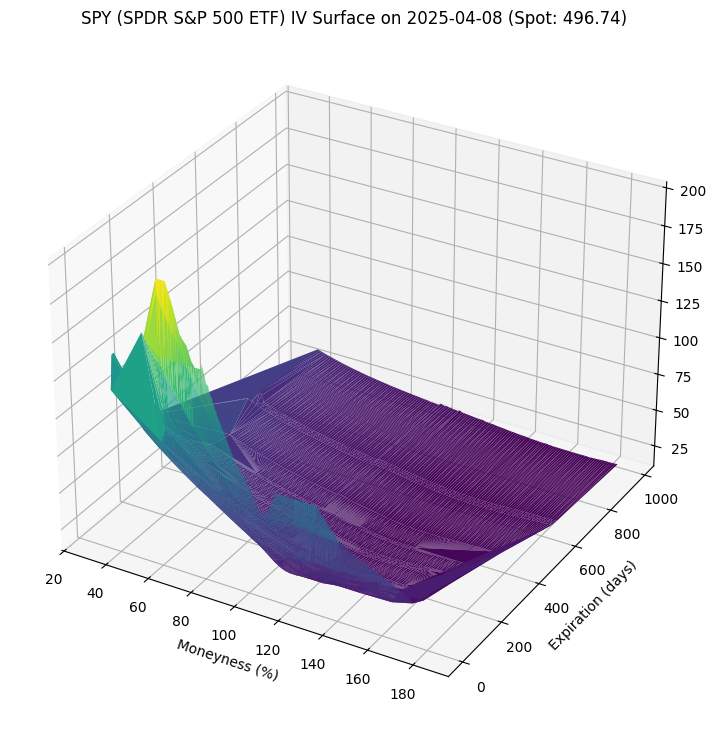

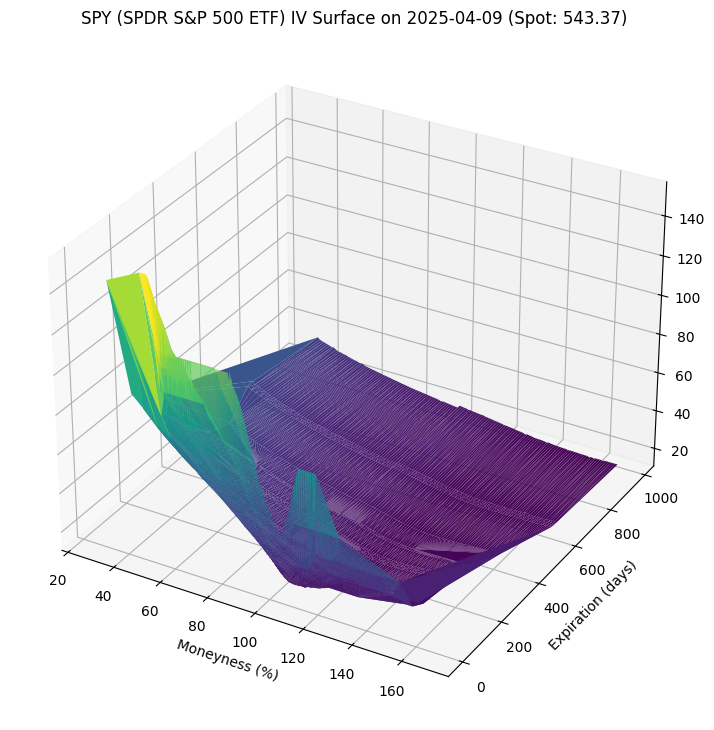

In [21]:
plot_iv_surfaces(
    df_call_iv_surface_one_day_before,
    df_put_iv_surface_onde_day_before,
    spot_price=spot_yst,
    as_of_date=one_day_before,
)

plot_iv_surfaces(
    df_call_iv_surface,
    df_put_iv_surface,
    spot_price=spot_today,
    as_of_date=start_date,
)

### <u>Why the IV Surface Dropped on April 9</u>

The IV surface is lower on April 9 because the strong rally reduced market uncertainty and demand for hedging. As put prices fell and call–put parity adjusted call IV accordingly, implied volatilities declined across strikes and maturities, resulting in a broadly lower surface.
